In [33]:
from tqdm import tqdm
import json
import os
import pandas as pd
import numpy as np
import pylab as plt


In [6]:
from numba import jit
import scipy.stats as sstats

@jit(nopython=True)
def lognorm_pdf(x, mu, sigma):
    ''' PDF of the log-normal distribution.'''
    out = 1.0/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(sigma**2))
    
    return out

In [7]:
@jit(nopython=True)
def norm_pdf(x, mu, sigma):

    out = 1.0/(sigma*np.sqrt(2*np.pi))*np.exp(-((x-mu)**2)/(sigma**2))

    return out

In [8]:
@jit(nopython=True)
def p_o_G_s(o, s, mu_l, sigma_l, sigma_alpha_2):
    p_l = lognorm_pdf(o[0], mu_l[s], sigma_l[s]) 
    if s == 0:
        p_alpha = 1/(2*np.pi)
    else:
        p_alpha = norm_pdf(o[1], 0.0, sigma_alpha_2)

    p_o_G_s = p_l*p_alpha
    
    if p_o_G_s < 10**(-20):
        p_o_G_s = 10**(-20)
    
    return p_o_G_s

In [9]:
@jit(nopython=True)
def p_olog_G_s(o, s, mu_l, sigma_l, sigma_alpha_2):
    p_l = norm_pdf(o[0], mu_l[s], sigma_l[s]) 

    if s == 0:
        p_alpha = 1/(2*np.pi)
    else:
        p_alpha = norm_pdf(o[1], 0.0, sigma_alpha_2)

    p_o_G_s = p_l*p_alpha
    if p_o_G_s < 10**(-20):
        p_o_G_s = 10**(-20)
    return p_o_G_s

In [10]:
@jit(nopython=True)
def viterbi(T, pi, mu_l, sigma_l, sigma_alpha_2, O):
    """Viterbi algorithm for solving the uncovering problem

    Notebook: C5/C5S3_Viterbi.ipynb

    Args:
        T (np.ndarray): State transition probability matrix of dimension K x K
        pi (np.ndarray): Initial state distribution  of dimension K
        O (np.ndarray): Observation sequence of length N

    Returns:
        S_opt (np.ndarray): Optimal state sequence of length N
        D (np.ndarray): Accumulated probability matrix
        E (np.ndarray): Backtracking matrix
    """
    K = T.shape[0]    # Number of states
    N = len(O)  # Length of observation sequence

    # Initialize D and E matrices
    D = np.zeros((K, N)).astype(np.float64)
    E = np.zeros((K, N-1)).astype(np.int32)
    D[:, 0] = pi #np.multiply(C, B[:, O[0]])

    # Compute D and E in a nested loop
    for n in range(1, N):
        for i in range(K):
            temp_product = np.multiply(T[:, i], D[:, n-1])
            D[i, n] = np.max(temp_product) * p_o_G_s(O[n], i, mu_l, sigma_l, sigma_alpha_2)
            E[i, n-1] = np.argmax(temp_product)

    # Backtracking
    S_opt = np.zeros(N).astype(np.int32)
    S_opt[-1] = np.argmax(D[:, -1])
    for n in range(N-2, -1, -1):
        S_opt[n] = E[int(S_opt[n+1]), n]

    return S_opt, D, E

In [11]:
def convert_to_cartesian(o):
    X = np.zeros(o.shape, dtype=float)
    X[:,1] = np.cumsum(o[:,1])
    X[:,0] = np.cumsum(o[:,0]*np.cos(X[:,1]))
    X[:,1] = np.cumsum(o[:,0]*np.sin(X[:,1]))
    
    return X

In [40]:
def convert_to_planar(X, dt=1.0):
    X_diff = np.diff(X, axis=0)
    l = np.sqrt(X_diff[:,0]**2+X_diff[:,1]**2)/dt + np.random. uniform(0.0, 0.000001)
    correct_idx = (l>0.0).nonzero()
    gamma = np.arctan2(X_diff[:,1],X_diff[:,0])
    alpha = np.diff(gamma)
    alpha[alpha>np.pi] = alpha[alpha>np.pi] - 2*np.pi
    alpha[alpha<-np.pi] = alpha[alpha<-np.pi] + 2*np.pi

    return l[1:], alpha[:-2]

  0%|          | 0/1 [00:00<?, ?it/s]

[21]
[93]
[414]
[329]
[  6  39  61  77  91 177]
[  7 326 374 449]
[870 871]
[  6   7  21  30  60  61  62  63  64  66  93 102 103 131 153 154]
[521 522]
[14 20 29 76 98]
[139 188 206 363 426 644 740 877 941 966]
[  3   4  17  41 132 133 134 159 160 226 227 249 250 364 365 439 440 441
 447 470 471 494]
[  7  19  31  51  68  71  80 115 119 121 123 129 132 144 147 169 203 232
 259 272 296]
[ 42  69  86 140 155 177 193]
[ 122  541  687  775  795  912  963 1247 1260 1289 1543 1631 1689 2066]


100%|██████████| 1/1 [00:06<00:00,  6.58s/it]


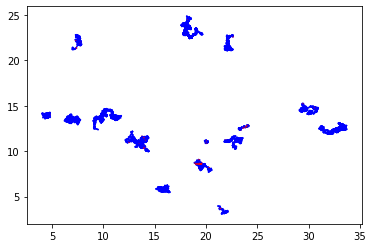

In [53]:
with open('/data/norm_list.txt') as f_norm:
    norm_tables = f_norm.read().splitlines()

key_counter = 0
for table in tqdm(norm_tables[:1]):
    #print(table)
    d = table[:table.rfind('/')+1]
    #print(d)
    tracks = pd.read_csv(d + 'Track_Data.xls', sep='\t')
    with open(d + "fitted_params.json", "r") as read_file:
        params = json.load(read_file)
    for track in np.unique(tracks['TRACK_ID'])[:100]:
        track0 = tracks.loc[tracks['TRACK_ID']==track]
        key_in_track = True
        track_keys = []
        while key_in_track:
            track_keys.append(key_counter)
            next_tracklet = int(params[str(key_counter)]['track_id'][:params[str(key_counter)]['track_id'].rfind('.')])
            if next_tracklet == track:
                key_counter += 1
            else:
                key_in_track = False
        
        pi_tot = np.zeros(2)
        T_tot = np.zeros((2,2))
        mu_tot = np.zeros(2)
        sigma_tot = np.zeros(2)
        for k in track_keys:
            key = str(k)
            pi_tot += np.array(params[key]['pi'])
            mu_tot += np.array(params[key]['mu_l'])
            sigma_tot += params[key]['sigma_l']
            T_tot[0] += np.array(params[key]['pi'])[0]*np.array(params[key]['T'])[0]
            T_tot[1] += np.array(params[key]['pi'])[1]*np.array(params[key]['T'])[1]
        
        T_tot[0] = T_tot[0]/np.sum(T_tot[0])
        T_tot[1] = T_tot[1]/np.sum(T_tot[1])
        pi_tot = pi_tot / len(track_keys)
        mu_tot = mu_tot / len(track_keys)
        sigma_tot = sigma_tot / len(track_keys)
        
        X = np.array([track0['POSITION_X'], track0['POSITION_Y']]).T
        l, alpha = convert_to_planar(X)
        o = np.array([l[1:-1], alpha]).T
        if o.shape[0] > 2:
            s_est, D, E = viterbi(T_tot, pi_tot, mu_tot, sigma_tot, float(params['0']['sigma_alpha_2']), o)
            if s_est.nonzero()[0].shape[0]>0:
                print(s_est.nonzero()[0])
                s_1_idx = (s_est==0)
                s_2_idx = (s_est==1)
                for ii in range(X.shape[0]-5):
                    if s_est[ii+1] == 0:
                        plt.plot(X[ii+1:ii+3,0], X[ii+1:ii+3,1], c='blue')
                    else:
                        plt.plot(X[ii+1:ii+3,0], X[ii+1:ii+3,1], c='red')
    